### Import Libraries and Read Data

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-dark')

In [3]:
## Read Data for Cases, Deaths and Recoveries
confirmed_cases_raw = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_raw = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_raw = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')


In [4]:
confirmed_cases_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,40,40,74,84,94,110,110,120,170,174
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,223,243
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,201,230,264,302,367,409,454,511,584,716
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,113,133,164,188,224,267,308,334,370,376
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,3,3,3,4,4,5,7,7,7


In [5]:
### Melt the dateframe into the right shape and set index
def melt_data(df_raw, drop_country=None):
    df_cleaned = df_raw.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_name='Cases',
                             var_name='Date')
    df_cleaned = df_cleaned.set_index(['Country/Region', 'Province/State', 'Date'])
    if drop_country:
        df_cleaned.drop(drop_country, level=0, inplace=True)
    return df_cleaned


### Get Country-wise Data
def country_wise(df_cleaned, oldname, newname):
    df_country = df_cleaned.groupby(['Country/Region', 'Date'])['Cases'].sum().reset_index()
    df_country = df_country.set_index(['Country/Region', 'Date'])
    df_country.index = df_country.index.set_levels(
        [df_country.index.levels[0], pd.to_datetime(df_country.index.levels[1])])
    df_country = df_country.sort_values(['Country/Region', 'Date'], ascending=True)
    df_country = df_country.rename(columns={oldname: newname})
    return df_country


### Get DailyData from Cumulative sum
def dailydata(dfcountry, oldname, newname):
    dfcountrydaily = dfcountry.groupby(level=0).diff().fillna(0)
    dfcountrydaily = dfcountrydaily.rename(columns={oldname: newname})
    return dfcountrydaily

In [6]:
# Clean all datasets
confirmed_cases = melt_data(confirmed_cases_raw, ['China', 'Mainland China'])
deaths = melt_data(deaths_raw, ['China', 'Mainland China'])
recoveries = melt_data(recoveries_raw, ['China', 'Mainland China'])

In [7]:
confirmed_cases.head()

,,,Lat,Long,Cases
Country/Region,Province/State,Date,,,
Afghanistan,NaN,1/22/20,33.0000,65.0000,0
Albania,NaN,1/22/20,41.1533,20.1683,0
Algeria,NaN,1/22/20,28.0339,1.6596,0
Andorra,NaN,1/22/20,42.5063,1.5218,0
Angola,NaN,1/22/20,-11.2027,17.8739,0


In [8]:
# Get country-wise data
confirmed_cases_country = country_wise(confirmed_cases, 'Cases', 'Total Confirmed Cases')
deaths_country = country_wise(deaths, 'Cases', 'Total Deaths')
recoveries_country = country_wise(recoveries, 'Cases', 'Total Recoveries')

In [9]:
# Get Daily Data
new_cases_country = dailydata(confirmed_cases_country, 'Total Confirmed Cases', 'Daily New Cases')
new_deaths_country = dailydata(deaths_country, 'Total Deaths', 'Daily New Deaths')
new_recoveries_country = dailydata(recoveries_country, 'Total Recoveries', 'Daily New Recoveries')

In [11]:
covid_cases = pd.merge(confirmed_cases_country, new_cases_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, new_deaths_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, deaths_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, recoveries_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, new_recoveries_country, how='left', left_index=True, right_index=True)


covid_cases['Active Cases'] = covid_cases['Total Confirmed Cases'] - covid_cases[
    'Total Deaths'] - covid_cases['Total Recoveries']
covid_cases['Share of Recoveries - Closed Cases'] = np.round(covid_cases['Total Recoveries'] / (
        covid_cases['Total Recoveries'] + covid_cases['Total Deaths']), 2)
covid_cases['Death to Cases Ratio'] = np.round(
    covid_cases['Total Deaths'] / covid_cases['Total Confirmed Cases'], 3)


In [12]:
global_totals = covid_cases.reset_index().groupby('Date').sum()
global_totals['Share of Recoveries - Closed Cases'] = np.round(
    global_totals['Total Recoveries'] / (global_totals['Total Recoveries'] + global_totals['Total Deaths']), 2)
global_totals['Death to Cases Ratio'] = np.round(global_totals['Total Deaths'] / global_totals['Total Confirmed Cases'], 3)
global_totals.tail(2)

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-03-30,700167,62172.0,3653.0,34274,88643,15143.0,577250,0.72,0.049
2020-03-31,775208,75041.0,4524.0,38798,101828,13185.0,634582,0.72,0.050


# Plot Global Total Cases

In [13]:
global_totals.iloc[-1]

Total Confirmed Cases                 775208.00
Daily New Cases                        75041.00
Daily New Deaths                        4524.00
Total Deaths                           38798.00
Total Recoveries                      101828.00
Daily New Recoveries                   13185.00
Active Cases                          634582.00
Share of Recoveries - Closed Cases         0.72
Death to Cases Ratio                       0.05
Name: 2020-03-31 00:00:00, dtype: float64

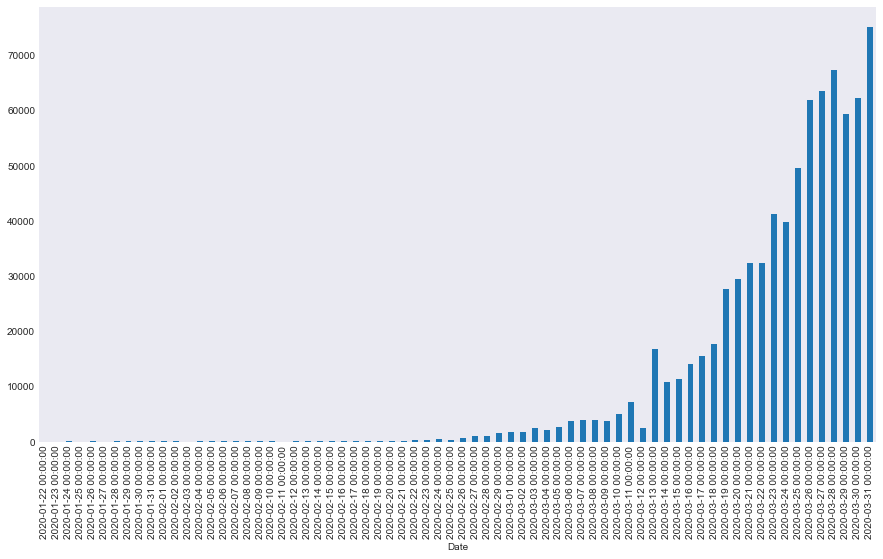

In [14]:
#plt.plot(GlobalTotals['Daily New Cases'])
global_totals['Daily New Cases'].plot.bar()

In [15]:
#plt.plot(GlobalTotals['Daily New Cases'])
global_totals['growth'] = global_totals['Daily New Cases'] / global_totals['Active Cases']

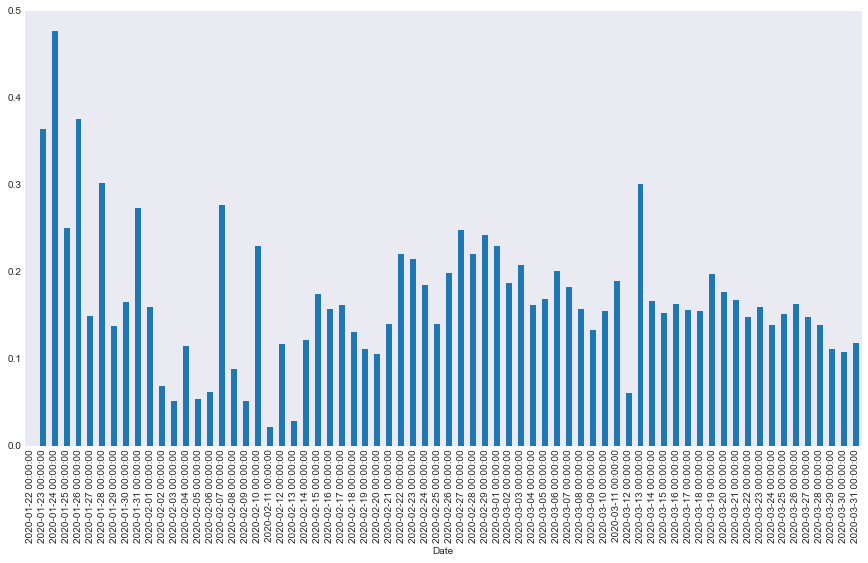

In [16]:
global_totals['growth'].plot.bar()

# Explore Country Specific Data

In [17]:
germany = covid_cases.loc['Germany'].copy()
germany.tail()

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-03-27,50871,6933.0,75.0,342,6658,985.0,43871,0.95,0.007
2020-03-28,57695,6824.0,91.0,433,8481,1823.0,48781,0.95,0.008
2020-03-29,62095,4400.0,100.0,533,9211,730.0,52351,0.95,0.009
2020-03-30,66885,4790.0,112.0,645,13500,4289.0,52740,0.95,0.010
2020-03-31,71808,4923.0,130.0,775,16100,2600.0,54933,0.95,0.011


In [18]:
south_korea = covid_cases.loc['Korea, South'].copy()
south_korea.tail()

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-03-27,9332,91.0,8.0,139,4528,384.0,4665,0.97,0.015
2020-03-28,9478,146.0,5.0,144,4811,283.0,4523,0.97,0.015
2020-03-29,9583,105.0,8.0,152,5033,222.0,4398,0.97,0.016
2020-03-30,9661,78.0,6.0,158,5228,195.0,4275,0.97,0.016
2020-03-31,9786,125.0,4.0,162,5408,180.0,4216,0.97,0.017


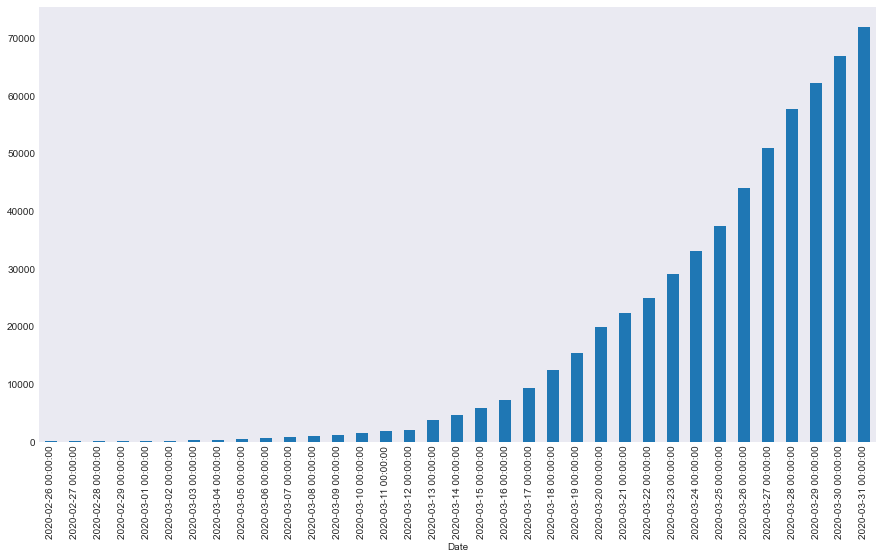

In [19]:
germany['Total Confirmed Cases'].iloc[-35:].plot.bar()

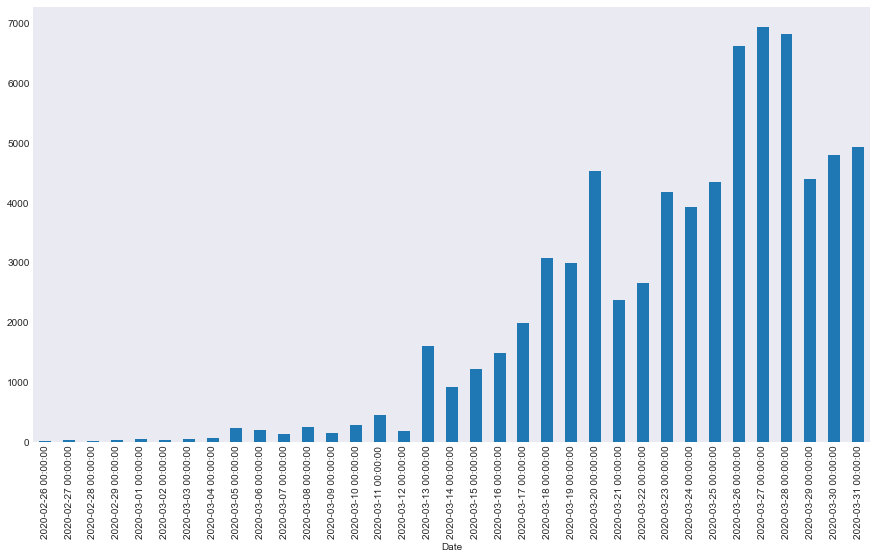

In [20]:
germany['Daily New Cases'].iloc[-35:].plot.bar()

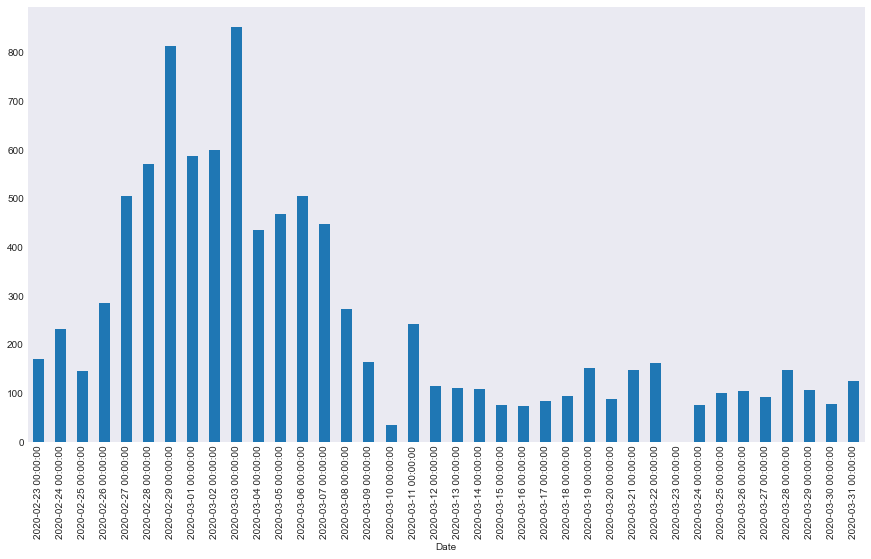

In [21]:
south_korea['Daily New Cases'].iloc[-38:].plot.bar()

In [22]:
germany['growth rate'] = germany['Daily New Cases'] / germany['Active Cases']

In [23]:
past_window = 36

In [24]:
germany_growth_moving_average = germany['growth rate'].iloc[-past_window:].rolling(window=3).mean()
germany_growth_ema = germany['growth rate'].iloc[-past_window:].ewm(span=6,adjust=False).mean()

Text(0.5, 1.0, 'Growth = Daily New Cases / Active Cases')

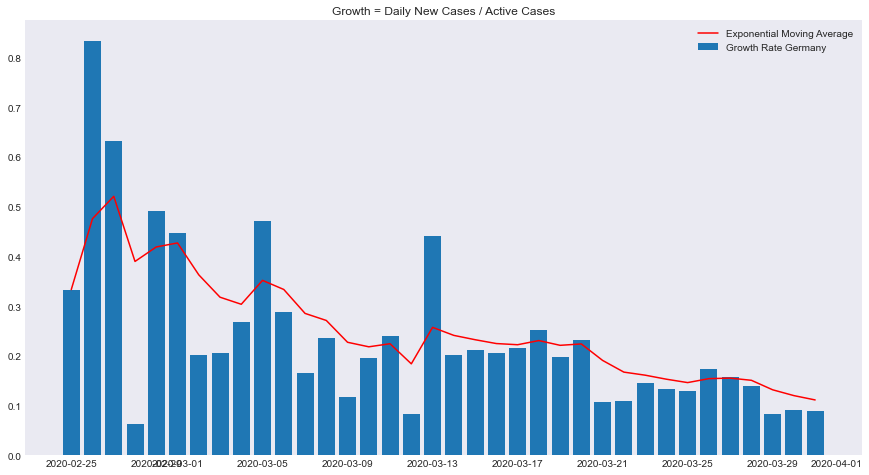

In [25]:
plt.bar(germany.iloc[-past_window:].index, germany['growth rate'].iloc[-past_window:], label='Growth Rate Germany')
#plt.plot(germany_growth_moving_average.index, germany_growth_moving_average, label='Moving Average', color='red')
plt.plot(germany_growth_ema.index, germany_growth_ema, label='Exponential Moving Average', color='red')

plt.legend(loc='best')
plt.title('Growth = Daily New Cases / Active Cases')

In [26]:
germany['growth rate'].tail(10)

Date
2020-03-22    0.108514
2020-03-23    0.145917
2020-03-24    0.132833
2020-03-25    0.129193
2020-03-26    0.174088
2020-03-27    0.158032
2020-03-28    0.139891
2020-03-29    0.084048
2020-03-30    0.090823
2020-03-31    0.089618
Name: growth rate, dtype: float64

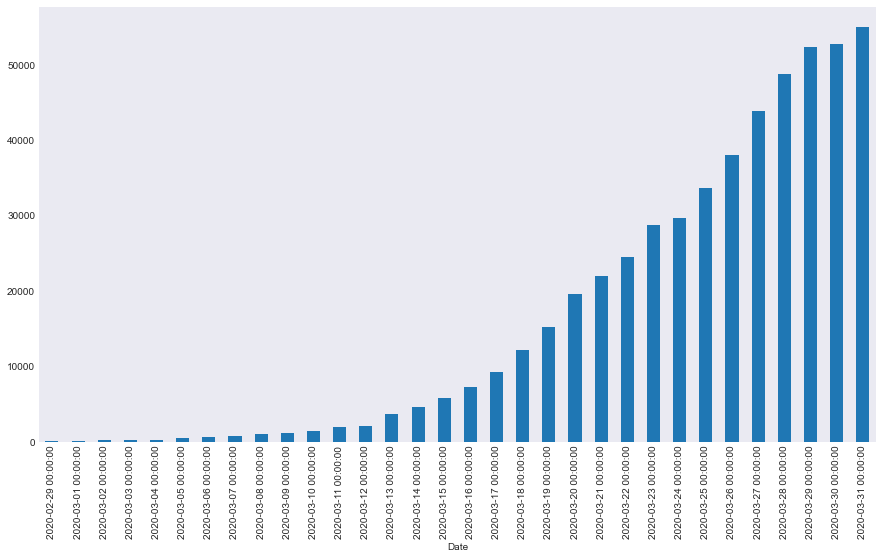

In [27]:
germany['Active Cases'].iloc[-32:].plot.bar()

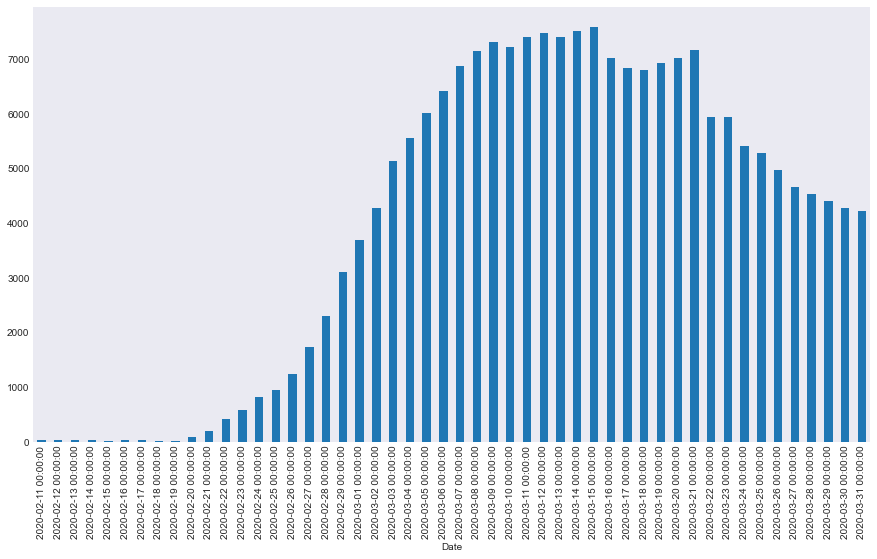

In [28]:
south_korea['Active Cases'].iloc[-50:].plot.bar()

In [29]:
south_korea['growth rate'] = south_korea['Daily New Cases'] / south_korea['Active Cases']

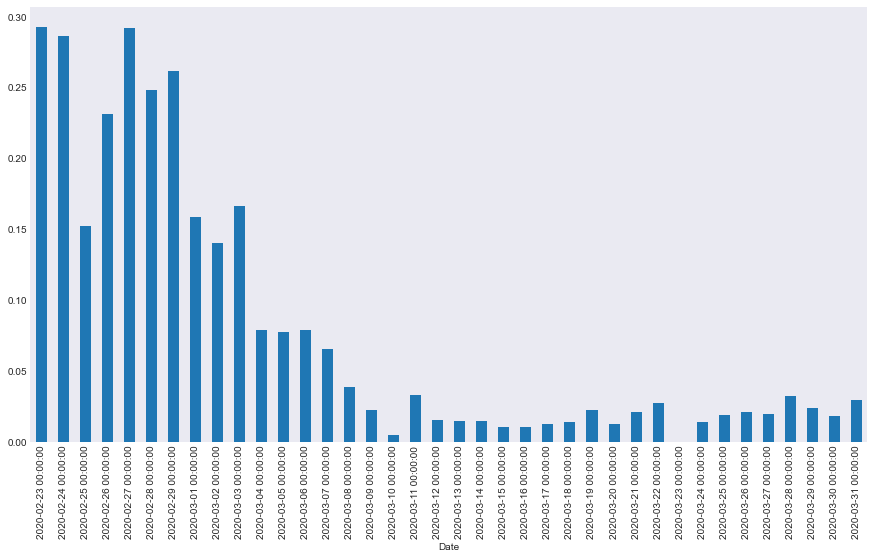

In [30]:
south_korea['growth rate'].iloc[-38:].plot.bar()

In [31]:
south_korea['growth rate'].tail(10)

Date
2020-03-22    0.027268
2020-03-23    0.000000
2020-03-24    0.014048
2020-03-25    0.018936
2020-03-26    0.020942
2020-03-27    0.019507
2020-03-28    0.032279
2020-03-29    0.023874
2020-03-30    0.018246
2020-03-31    0.029649
Name: growth rate, dtype: float64